In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle
from bagpy import bagreader
import open3d as o3d
import sensor_msgs.point_cloud2 as pc2
from rosbags.image import message_to_cvimage
import pyrealsense2 as rs2
if (not hasattr(rs2, 'intrinsics')):
    import pyrealsense2.pyrealsense2 as rs2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import matplotlib.pyplot as plt

In [3]:
# load synced data 
sync_data = pd.read_pickle("synced_data.pkl")
#sync_data = pickle.load(open("synced_data.pkl", "rb"))

In [3]:
def msgs(bag):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    print("Extract messages")
    topic_list = [
        "/camera_left/color/image_raw",
        "/detected_persons/yolo",
        "/front_lidar/velodyne_points"
    ]
    image_msgs = []
    pc_msgs = []
    pers_msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == "/camera_left/color/image_raw":
            image_msgs.append(msg)

        if topic =="/detected_persons/yolo":
            pers_msgs.append(msg)

        if topic == "/front_lidar/velodyne_points":
            pc_msgs.append(msg)


    bag.close()

    data_params = {
        "image_msgs": image_msgs,
        "pc_msgs": pc_msgs,
        "pers_msgs": pers_msgs,
    }

    return data_params

def create_detection_data(msgs):
    print("Get detection data")
    timestamps = []
    detections = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        detection = []
        # reduce information about each detection to the necessary things
        for j in i.detections:
            # save from detections: confidence score, positionx, positiony, positionz, bboxx, bboxy, bboxw, bboxh
            conf_score = j.confidence
            pos = [j.pose.pose.position.x, j.pose.pose.position.y, j.pose.pose.position.z]
            bbox = [j.bbox_x, j.bbox_y, j.bbox_w, j.bbox_h]
            detection.append([conf_score, pos, bbox])
        detections.append(detection)
    data = {"timestamps": np.array(timestamps), "detections": detections}
    return data

def create_img_data(msgs):
    print("Get image data")
    timestamps = []
    img_msgs = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        img = message_to_cvimage(i)
        img_msgs.append(img)
    data = {"timestamps": np.array(timestamps), "img_msgs": img_msgs}
    return data

def pc_to_grid(tmp_msg):
    points_obj = pc2.read_points(tmp_msg, skip_nans=True, field_names=("x", "y", "z"))
    pc = np.array(list(points_obj), dtype=np.float32)
    pc[:,2] = 0
    #print(pc.shape)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    #print(len(pcd.points))

    # fit to unit cube
    pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
            center=pcd.get_center())
    #o3d.visualization.draw_geometries([pcd])
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                voxel_size=0.01)
    #o3d.visualization.draw_geometries([voxel_grid])
    voxels = voxel_grid.get_voxels()  # returns list of voxels
    indices = np.stack(list(vx.grid_index for vx in voxels))
    voxel_coord = np.stack(list(voxel_grid.get_voxel_center_coordinate(vx) for vx in indices))
    #print("voxel_coord: ", voxel_coord.shape)
    #print("indices: ", indices)

    return voxel_coord

def create_vox_data(msgs):
    print("Get scene data")
    timestamps = []
    voxel_msgs = []
    for i in msgs:
        timestamps.append(i.header.stamp.to_time())
        vox = pc_to_grid(i)
        voxel_msgs.append(vox)
    data = {"timestamps": np.array(timestamps), "vox_msgs": voxel_msgs}
    return data

def sync_data(d1,d2,d3):
    print("Synchronize data")
    pd.set_option('display.float_format', '{:.2f}'.format)

    df_pers = pd.DataFrame.from_dict(data=d1)
    df_img = pd.DataFrame.from_dict(data=d2)
    df_vox = pd.DataFrame.from_dict(data=d3)

    df_pers.sort_values(by="timestamps",inplace=True)
    df_img.sort_values(by="timestamps",inplace=True)
    df_vox.sort_values(by="timestamps", inplace=True)

    merged_df = pd.merge_asof(df_pers, df_img, on="timestamps", direction="nearest")
    merged_df = pd.merge_asof(merged_df, df_vox, on="timestamps", direction="nearest")

    return merged_df

In [4]:
start_time = time.time()

path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader

data_params = msgs(bag)

detect_data = create_detection_data(data_params["pers_msgs"])
img_data = create_img_data(data_params["image_msgs"])
vox_data = create_vox_data(data_params["pc_msgs"])

sync_data = sync_data(detect_data, img_data, vox_data)
sync_data.to_pickle("synced_data.pkl")

print("--- %s seconds ---" % (time.time() - start_time))

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.
Extract messages
Get detection data
Get image data
Get scene data
Synchronize data
--- 51.10482597351074 seconds ---


In [5]:
sync_data

,timestamps,detections,img_msgs,vox_msgs
0,1616680352.71,"[[0.990127444267273, [-0.38936211035001733, -0...","[[[4, 6, 24], [4, 6, 24], [5, 4, 28], [4, 3, 2...","[[2.0915105177652547, 0.4666379365424603, 0.0]..."
1,1616680352.83,"[[0.9889856576919556, [2.434882329030057, 0.00...","[[[4, 3, 27], [3, 2, 26], [3, 7, 21], [4, 8, 2...","[[2.079590391150424, 1.0561067187927429, 0.0],..."
2,1616680352.90,"[[0.993348240852356, [-0.40092064309254183, -0...","[[[7, 6, 26], [8, 7, 27], [7, 6, 26], [6, 4, 2...","[[2.104058821505651, 1.0569809990641525, 0.0],..."
3,1616680353.03,"[[0.9944700002670288, [2.383170036323165, 0.00...","[[[5, 4, 28], [4, 3, 27], [7, 8, 19], [6, 6, 1...","[[2.266729587949038, 1.0921466609381505, 0.0],..."
4,1616680353.13,"[[0.9944361448287964, [-0.3997900988003534, -0...","[[[6, 11, 19], [5, 10, 18], [6, 9, 20], [6, 9,...","[[2.2299857742044473, 0.8600353272933052, 0.0]..."
...,...,...,...,...
1041,1616680482.27,"[[0.9972365498542786, [-3.2723291423496175, -0...","[[[124, 114, 112], [125, 115, 114], [129, 114,...","[[2.1705472472743184, 0.4704690854345784, 0.0]..."
1042,1616680482.28,"[[0.9976322650909424, [-2.485738105996217, -0....","[[[221, 215, 192], [219, 212, 190], [210, 193,...","[[2.1705472472743184, 0.4704690854345784, 0.0]..."
1043,1616680482.52,"[[0.9987186193466187, [3.7260399079066175, -0....","[[[253, 255, 253], [252, 255, 252], [213, 204,...","[[2.1705472472743184, 0.4704690854345784, 0.0]..."
1044,1616680482.62,"[[0.9985901713371277, [3.078814208471769, -0.6...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[2.1705472472743184, 0.4704690854345784, 0.0]..."


# Load tracking from rosbags

In [7]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag, topic_):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        topic_
    ]
    msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == topic_:
            msgs.append(msg)

    bag.close()


    return msgs
track_msgs = msgs(bag, "/rwth_tracker/tracked_persons")
#topic_msgs = msgs(bag, "/front_lidar/scan")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [100]:
track_msgs[13]

header: 
  seq: 100
  stamp: 
    secs: 1616680355
    nsecs: 306141024
  frame_id: "tf_qolo_world"
tracks: 
  - 
    track_id: 0
    is_occluded: False
    is_matched: True
    detection_id: 783
    age: 
      secs: 0
      nsecs: 690209184
    height: 1.85
    pose: 
      pose: 
        position: 
          x: -5.618217703855409
          y: -2.773294824338567
          z: 0.0
        orientation: 
          x: 0.0
          y: 0.0
          z: 0.0
          w: 1.0
      covariance: [0.015873886401409708, -2.9225747895136876e-19, 0.0, 0.0, 0.0, 0.0, 6.061668968609193e-19, 0.015873886401409704, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030461741978670857]
    twist: 
      twist: 
        linear: 
          x: 0.0
          y: 0.0
          z: 0.0
        angular: 
          x: 0.0
          y: 0.0
          z: 0.0
      covariance: [0.11983981582149075, 0.0, 0.0, 0.0, 0.

In [9]:
t = track_msgs[13].header.stamp.to_time()
t

1616680355.3061411

In [10]:
df_sort = sync_data.iloc[(sync_data['timestamps']-t).abs().argsort()[:2]]

In [11]:
df_sort

,timestamps,detections,img_msgs,vox_msgs
25,1616680355.28,"[[0.9895936250686646, [-1.4351424973821274, 0....","[[[12, 9, 24], [12, 9, 24], [9, 7, 25], [9, 7,...","[[2.295765774061707, 0.6001053299546912, 0.0],..."
26,1616680355.38,"[[0.9988284707069397, [0.2839580336621146, -0....","[[[11, 10, 22], [10, 8, 20], [10, 8, 20], [10,...","[[2.5310998052316034, 0.5120377779231945, 0.0]..."


In [12]:
dets = df_sort.iloc[0]["detections"]
dets

[[0.9895936250686646,
  [-1.4351424973821274, 0.0071728618377681404, 9.357],
  [205.0, 198.0, 38.0, 100.0]],
 [0.9874863028526306,
  [3.421109849464678, 0.010640090019046894, 13.879999999999999],
  [461.0, 214.0, 20.0, 69.0]],
 [0.9711163640022278,
  [0.17196133082773796, -0.13906942481510462, 3.013],
  [300.0, 62.0, 108.0, 314.0]],
 [0.9276376962661743,
  [-0.577050397675523, 0.008607894151576196, 11.229000000000001],
  [278.0, 201.0, 18.0, 94.0]],
 [0.8983154296875,
  [2.9175303942943716, -0.00906633324962026, 10.648],
  [479.0, 210.0, 19.0, 75.0]],
 [0.8804683685302734,
  [2.0211839873749287, 0.16322212786532486, 10.648],
  [424.0, 222.0, 24.0, 71.0]],
 [0.8386221528053284,
  [-3.5577846875755252, -0.0706727625622207, 9.65],
  [74.0, 189.0, 35.0, 108.0]],
 [0.815439760684967,
  [1.3078256276125617, 0.03582770996568465, 8.951],
  [393.0, 202.0, 32.0, 96.0]]]

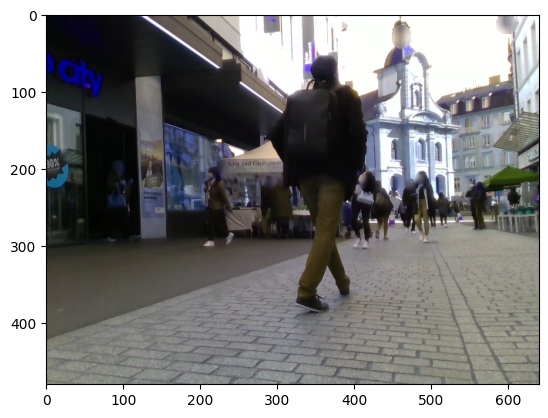

In [62]:
img = df_sort.iloc[0]["img_msgs"]
plt.imshow(img)

In [54]:
p_pos = []
for p in topic_msgs[13].pedestrians:
    pos = [p.traj_x[-1], p.traj_y[-1], p.traj_z[-1]]
    p_pos.append(pos)

p_pos

[[-5.618217703855409, -2.773294824338567, -2.773294824338567],
 [-4.829855241807766, -1.7724969268713653, -1.7724969268713653],
 [0.1671394258458747, -1.0475639872680023, -1.0475639872680023],
 [2.8805702748147253, 5.869312637507842, 5.869312637507842]]

In [13]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag, topic_):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        topic_
    ]
    msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == topic_:
            msgs.append(msg)

    bag.close()


    return msgs
#topic_msgs = msgs(bag, "/detected_persons/yolo")
#topic_msgs = msgs(bag, "/drow_detected_persons_rear")
topic_msgs = msgs(bag, "/tf")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [14]:
left_cam_msgs = []
for m in topic_msgs:
    for j in  m.transforms:
        if j.child_frame_id == "camera_left_color_optical_frame":
            left_cam_msgs.append(m.transforms)

In [120]:
left_cam_msgs[0][0].header.stamp.to_time()

1616680353.546507

In [15]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag, topic_):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        topic_
    ]
    msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == topic_:
            msgs.append(msg)

    bag.close()


    return msgs
#pers_msgs = msgs(bag, "/detected_persons/yolo")
#topic_msgs = msgs(bag, "/drow_detected_persons_rear")
topic_msgs = msgs(bag, "/tf_static")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_0325_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [16]:
def create_tf_data(msgs):
    print("Get tf data")
    timestamps = []
    tf_msgs = []
    for i in msgs:
        timestamps.append(i[0].header.stamp.to_time())
        transform = i[0].transform
        tf_msgs.append(transform)
    data = {"timestamps": np.array(timestamps), "tf_msgs": tf_msgs}
    return data

In [17]:
tf_data = create_tf_data(left_cam_msgs)
df_tf = pd.DataFrame.from_dict(data=tf_data)
tf_data["timestamps"]


Get tf data


array([1.61668035e+09, 1.61668035e+09, 1.61668035e+09, ...,
       1.61668048e+09, 1.61668048e+09, 1.61668048e+09])

In [18]:
# match timestamp of tf, detection and tracker
track = track_msgs[13] # track to t
t = track.header.stamp.to_time()
df_sort = sync_data.iloc[(sync_data['timestamps']-t).abs().argsort()[:2]]
dets = df_sort.iloc[0]["detections"] # dets to t

tf_s = df_tf.iloc[(df_tf['timestamps']-t).abs().argsort()[:2]]
tf = tf_s.iloc[0]["tf_msgs"] # dets to t


In [182]:
dets

[[0.9895936250686646,
  [-1.4351424973821274, 0.0071728618377681404, 9.357],
  [205.0, 198.0, 38.0, 100.0]],
 [0.9874863028526306,
  [3.421109849464678, 0.010640090019046894, 13.879999999999999],
  [461.0, 214.0, 20.0, 69.0]],
 [0.9711163640022278,
  [0.17196133082773796, -0.13906942481510462, 3.013],
  [300.0, 62.0, 108.0, 314.0]],
 [0.9276376962661743,
  [-0.577050397675523, 0.008607894151576196, 11.229000000000001],
  [278.0, 201.0, 18.0, 94.0]],
 [0.8983154296875,
  [2.9175303942943716, -0.00906633324962026, 10.648],
  [479.0, 210.0, 19.0, 75.0]],
 [0.8804683685302734,
  [2.0211839873749287, 0.16322212786532486, 10.648],
  [424.0, 222.0, 24.0, 71.0]],
 [0.8386221528053284,
  [-3.5577846875755252, -0.0706727625622207, 9.65],
  [74.0, 189.0, 35.0, 108.0]],
 [0.815439760684967,
  [1.3078256276125617, 0.03582770996568465, 8.951],
  [393.0, 202.0, 32.0, 96.0]]]

In [30]:
import cv2 as cv
size = (640,480)

# get video of images
img_array = []
for img in sync_data["img_msgs"]:
    img_array.append(img)

img_array = np.asarray(img_array)

out = cv.VideoWriter('video_imgs.avi', 0 ,15, size)

for i in range(len(img_array)):
    rgb_img = cv.cvtColor(img_array[i], cv.COLOR_RGB2BGR)
    out.write(rgb_img)
out.release()

# MultiObjectTracker

In [5]:
test_syn_data = sync_data.copy().to_dict()

In [9]:
test_syn_data["detections"][0]

[[0.990127444267273,
  [-0.38936211035001733, -0.027513600453769067, 1.7850000000000001],
  [60.0, 10.0, 248.0, 457.0]],
 [0.9831373691558838,
  [2.410667697874895, 0.008024528985546318, 10.468],
  [445.0, 203.0, 32.0, 91.0]],
 [0.9594746232032776,
  [0.31285018181343915, 0.008856756519472875, 1.0],
  [503.0, 224.0, 19.0, 58.0]],
 [0.9560820460319519,
  [0.21125374263374497, 0.04262020508486316, 10.648],
  [313.0, 209.0, 36.0, 82.0]],
 [0.9410597085952759,
  [3.6003333378125513, 0.010072822971921917, 13.14],
  [479.0, 209.0, 19.0, 79.0]],
 [0.9355571269989014,
  [-0.5439076545621723, -0.029905580584438787, 12.11],
  [280.0, 208.0, 22.0, 77.0]],
 [0.9332028031349182,
  [-3.461251331711066, -0.07582901978074551, 7.181],
  [0.0, 167.0, 43.0, 149.0]],
 [0.9010993838310242,
  [0.3419893399878706, 0.007238720633720164, 1.0],
  [521.0, 227.0, 19.0, 51.0]]]

In [6]:
import cv2 as cv
from motpy import Detection, MultiObjectTracker
import torch

def draw_boxes(frame, track_results, id_dict):
    # Draw bounding boxes for tracked objects
    for object in track_results:
        #print("object: ", object)
        x, y, w, h = object.box
        x, y, w, h = int(x), int(y), int(w), int(h)
        object_id = object.id
        confidence = object.score
        cv.rectangle(frame, (x, y), (w, h), (0, 255, 0), 2)
        cv.putText(frame, f"{str(id_dict[object_id])}: {str(round(confidence[0], 2))}", (x, y - 10), cv.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv.putText(frame, "People Count: {}".format(len(track_results)), (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


def update_id_dict(id_dict, j, track_results):
    # Update the dictionary with new object IDs and corresponding labels
    for track_result in track_results:
        if track_result.id not in id_dict:
            id_dict[track_result.id] = j
            j += 1
    return id_dict, j



In [50]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# set base options for blazepose
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

I0000 00:00:1713428606.884070    7256 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c


In [7]:
import numpy as np
import os
import sys

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

2024-04-18 11:55:39.809973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 11:55:39.940056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 11:55:39.941773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 11:55:40.854469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor, reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor, 
                            reset_crop_region=False)

  return person
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def get_pose(frame, bbox):
    offset = 0
    #cropped_img = frame.copy()[bbox[1]-offset:bbox[3]+offset, bbox[0]-offset:bbox[2]+offset]
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    cropped_img = frame.copy()
    mp_im = mp.Image(image_format=mp.ImageFormat.SRGB, data=cropped_img)
    detection_result = detector.detect(mp_im)
    annotated_image = draw_landmarks_on_image(cropped_img, detection_result)
    print("detection result: ", detection_result)
    if len(detection_result.pose_landmarks) > 0:
      plt.imshow(annotated_image)
    return detection_result

def get_pose2(frame, bbox):
    #offset = 0
    #cropped_img = frame.copy()[bbox[1]-offset:bbox[3]+offset, bbox[0]-offset:bbox[2]+offset]
    cropped_img = frame.copy()[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    #cropped_img = frame.copy()
    person = detect(cropped_img)

    print("detection result: ", person)
    detections = []
    if len(person.keypoints) > 0:
        output_overlay = draw_prediction_on_image(
              cropped_img.astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        output_frame = cv.cvtColor(output_overlay, cv.COLOR_RGB2BGR)
        plt.imshow(output_frame)
        for keypoint in person.keypoints:
            detections.append([keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score])
    return detections



def update_dets(idx, track_res):
    for i in range(len(test_syn_data["detections"][idx])):
        obj = test_syn_data["detections"][idx][i]
        conf, pos, bbox_orig = obj
        x_min, y_min, w, h = bbox_orig
        bbox_orig = np.array([int(x_min), int(y_min), int(x_min+w), int(y_min+h)])
        # get bestimmt effizienter
        for obj in track_res:
            if np.array_equal(bbox_orig,obj.box):
                # get pose from blazepose
                poses = get_pose2(test_syn_data["img_msgs"][idx], bbox_orig)
                id = id_dict[obj.id]
                new_sync_data["detections"][idx][i] = [id, pos, bbox_orig, poses, conf]
        
        

In [10]:
new_sync_data = test_syn_data.copy()

In [11]:
new_sync_data["detections"]

{0: [[0.990127444267273,
   [-0.38936211035001733, -0.027513600453769067, 1.7850000000000001],
   [60.0, 10.0, 248.0, 457.0]],
  [0.9831373691558838,
   [2.410667697874895, 0.008024528985546318, 10.468],
   [445.0, 203.0, 32.0, 91.0]],
  [0.9594746232032776,
   [0.31285018181343915, 0.008856756519472875, 1.0],
   [503.0, 224.0, 19.0, 58.0]],
  [0.9560820460319519,
   [0.21125374263374497, 0.04262020508486316, 10.648],
   [313.0, 209.0, 36.0, 82.0]],
  [0.9410597085952759,
   [3.6003333378125513, 0.010072822971921917, 13.14],
   [479.0, 209.0, 19.0, 79.0]],
  [0.9355571269989014,
   [-0.5439076545621723, -0.029905580584438787, 12.11],
   [280.0, 208.0, 22.0, 77.0]],
  [0.9332028031349182,
   [-3.461251331711066, -0.07582901978074551, 7.181],
   [0.0, 167.0, 43.0, 149.0]],
  [0.9010993838310242,
   [0.3419893399878706, 0.007238720633720164, 1.0],
   [521.0, 227.0, 19.0, 51.0]]],
 1: [[0.9889856576919556,
   [2.434882329030057, 0.008162512861874015, 10.648],
   [443.0, 203.0, 34.0, 91.0]]

detection result:  Person(keypoints=[KeyPoint(body_part=<BodyPart.NOSE: 0>, coordinate=Point(x=129, y=2), score=0.29179493), KeyPoint(body_part=<BodyPart.LEFT_EYE: 1>, coordinate=Point(x=134, y=0), score=0.08844421), KeyPoint(body_part=<BodyPart.RIGHT_EYE: 2>, coordinate=Point(x=123, y=0), score=0.20009129), KeyPoint(body_part=<BodyPart.LEFT_EAR: 3>, coordinate=Point(x=135, y=-7), score=0.044142846), KeyPoint(body_part=<BodyPart.RIGHT_EAR: 4>, coordinate=Point(x=110, y=-5), score=0.010670845), KeyPoint(body_part=<BodyPart.LEFT_SHOULDER: 5>, coordinate=Point(x=175, y=5), score=0.7037065), KeyPoint(body_part=<BodyPart.RIGHT_SHOULDER: 6>, coordinate=Point(x=57, y=1), score=0.47281885), KeyPoint(body_part=<BodyPart.LEFT_ELBOW: 7>, coordinate=Point(x=206, y=74), score=0.34569845), KeyPoint(body_part=<BodyPart.RIGHT_ELBOW: 8>, coordinate=Point(x=25, y=74), score=0.7454287), KeyPoint(body_part=<BodyPart.LEFT_WRIST: 9>, coordinate=Point(x=201, y=68), score=0.2635059), KeyPoint(body_part=<BodyP

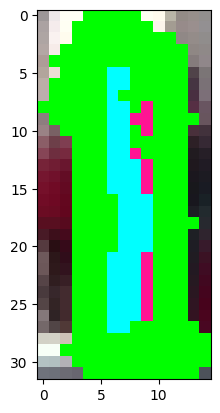

In [12]:
imgs = sync_data.iloc[:]["img_msgs"]

bboxes = []
scores = []
for d in sync_data.iloc[:]["detections"]:
    bbox_d = []
    scores_d = []
    for i in d:
        x_min, y_min, w, h = i[2]
        bbox_d.append([int(x_min), int(y_min), int(x_min+w), int(y_min+h)])
        scores_d.append([i[0]])
    bboxes.append(bbox_d)
    scores.append(scores_d)


# Initialize MultiObjectTracker
tracker = MultiObjectTracker(dt=1 / 15, tracker_kwargs={'max_staleness': 10})

# Initialize ID dictionary and counter
id_dict = {}
j = 0

for frame_id in range(len(imgs)):

    frame = np.asarray(imgs[frame_id].copy())


    detections = []

    # Pass YOLO detections to motpy
    for coord, score in zip(bboxes[frame_id], scores[frame_id]):
        detections.append(Detection(box=coord, score=score, class_id=25))

    # Perform object tracking
    tracker.step(detections=detections)
    track_results = tracker.active_tracks()

    # Update ID dictionary
    id_dict, j = update_id_dict(id_dict, j, track_results)

    #print(id_dict)
    update_dets(frame_id, track_results)

    # Draw bounding boxes on frame
    draw_boxes(frame, track_results, id_dict)
    cv.imwrite('FRAME.jpg', frame)


In [13]:
id_dict

{'ada06a0c-9aa9-4fbe-a0d7-c405818459ea': 0,
 'ec139fb8-f841-4a7f-8989-0e4e5712c96f': 1,
 '87a814bb-1575-43fa-807b-7b77b70b828c': 2,
 'dca38bfe-4411-4b6c-a9b3-733b29d1e6ad': 3,
 '1ee9021b-b754-4c44-89d5-2c88a17362d4': 4,
 '2e582044-9fcd-45be-85a0-3f15f37073e7': 5,
 '2e5a1250-ca3d-47c4-a417-9f9aa362745a': 6,
 '455cfba4-2c6d-4ef5-b223-2b1e9d109817': 7,
 '27b59d21-baf3-4b84-adbb-0b1c3f11b4b8': 8,
 'a565b6f2-1891-447e-97fa-4158ee15a228': 9,
 'fb59f36a-3bc0-41fd-b67d-3c5c6893c22b': 10,
 '9a28ae75-b858-416c-ad9c-a59c24e5dcad': 11,
 'a205e69e-8d12-428c-891f-ecd36772b834': 12,
 '99e161d5-0af0-494f-8388-aa4d4912dbc8': 13,
 '8c4a04fe-e78a-47bb-af8c-70362124ae31': 14,
 '80f1ca0a-26af-467e-aba8-c42627ab924e': 15,
 '9535ac5e-28f5-40b7-8833-be875272cf7c': 16,
 '93b30005-5646-4d00-b558-ff5e21dc5679': 17,
 '1ff885f6-e2b8-419f-ae23-081f3169c0d7': 18,
 'e13235ce-5188-4068-9de9-9b6fa1fa8f6c': 19,
 '7a739d4a-27eb-4a2c-a452-d888200fad7f': 20,
 '92eba0e5-acaf-415a-8972-da5d20997c17': 21,
 'b0180058-6822-4b5e

In [3]:
df = pd.read_csv("synced_full_data.csv")
df

,timestamps,detections,img_msgs,vox_msgs
0,1.616680e+09,"[[0, [-0.38936211035001733, -0.027513600453769...",[[[ 4 6 24]\n [ 4 6 24]\n [ 5 4 ...,[[2.09151052 0.46663794 0. ]\n [2.19151...
1,1.616680e+09,"[[0.9889856576919556, [2.434882329030057, 0.00...",[[[ 4 3 27]\n [ 3 2 26]\n [ 3 7 ...,[[2.07959039 1.05610672 0. ]\n [2.28959...
2,1.616680e+09,"[[0.993348240852356, [-0.40092064309254183, -0...",[[[ 7 6 26]\n [ 8 7 27]\n [ 7 6 ...,[[2.10405882 1.056981 0. ]\n [2.20405...
3,1.616680e+09,"[[0.9944700002670288, [2.383170036323165, 0.00...",[[[ 5 4 28]\n [ 4 3 27]\n [ 7 8 ...,[[2.26672959 1.09214666 0. ]\n [2.25672...
4,1.616680e+09,"[[0.9944361448287964, [-0.3997900988003534, -0...",[[[ 6 11 19]\n [ 5 10 18]\n [ 6 9 ...,[[2.22998577 0.86003533 0. ]\n [2.50998...
...,...,...,...,...
1041,1.616680e+09,"[[279, [-3.2723291423496175, -0.21280036753926...",[[[124 114 112]\n [125 115 114]\n [129 114 1...,[[2.17054725e+00 4.70469085e-01 0.00000000e+00...
1042,1.616680e+09,"[[0.9976322650909424, [-2.485738105996217, -0....",[[[221 215 192]\n [219 212 190]\n [210 193 1...,[[2.17054725e+00 4.70469085e-01 0.00000000e+00...
1043,1.616680e+09,"[[0.9987186193466187, [3.7260399079066175, -0....",[[[253 255 253]\n [252 255 252]\n [213 204 1...,[[2.17054725e+00 4.70469085e-01 0.00000000e+00...
1044,1.616680e+09,"[[0.9985901713371277, [3.078814208471769, -0.6...",[[[255 255 255]\n [255 255 255]\n [255 255 2...,[[2.17054725e+00 4.70469085e-01 0.00000000e+00...


In [33]:
unpickled_df = pd.read_pickle("synced_full_data.pkl")  
unpickled_df  

,timestamps,detections,img_msgs,vox_msgs
0,1.616680e+09,"[[0, [-0.38936211035001733, -0.027513600453769...","[[[4, 6, 24], [4, 6, 24], [5, 4, 28], [4, 3, 2...","[[5, 20], [15, 33], [12, 29], [11, 27], [19, 3..."
1,1.616680e+09,"[[1, [2.434882329030057, 0.008162512861874015,...","[[[4, 3, 27], [3, 2, 26], [3, 7, 21], [4, 8, 2...","[[3, 78], [24, 38], [19, 53], [1, 78], [16, 32..."
2,1.616680e+09,"[[0, [-0.40092064309254183, -0.021737212341631...","[[[7, 6, 26], [8, 7, 27], [7, 6, 26], [6, 4, 2...","[[6, 77], [16, 60], [46, 33], [2, 82], [26, 32..."
3,1.616680e+09,"[[1, [2.383170036323165, 0.008162512861874015,...","[[[5, 4, 28], [4, 3, 27], [7, 8, 19], [6, 6, 1...","[[25, 79], [24, 58], [23, 58], [21, 32], [23, ..."
4,1.616680e+09,"[[0, [-0.3997900988003534, -0.0190707714418641...","[[[6, 11, 19], [5, 10, 18], [6, 9, 20], [6, 9,...","[[25, 60], [53, 56], [24, 88], [27, 55], [25, ..."
...,...,...,...,...
1041,1.616680e+09,"[[279, [-3.2723291423496175, -0.21280036753926...","[[[124, 114, 112], [125, 115, 114], [129, 114,...","[[37, 70], [34, 56], [35, 61], [35, 37], [37, ..."
1042,1.616680e+09,"[[283, [-2.485738105996217, -0.100405655615125...","[[[221, 215, 192], [219, 212, 190], [210, 193,...","[[37, 70], [34, 56], [35, 61], [35, 37], [37, ..."
1043,1.616680e+09,"[[277, [3.7260399079066175, -0.623008068033155...","[[[253, 255, 253], [252, 255, 252], [213, 204,...","[[37, 70], [34, 56], [35, 61], [35, 37], [37, ..."
1044,1.616680e+09,"[[0.9985901713371277, [3.078814208471769, -0.6...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[37, 70], [34, 56], [35, 61], [35, 37], [37, ..."


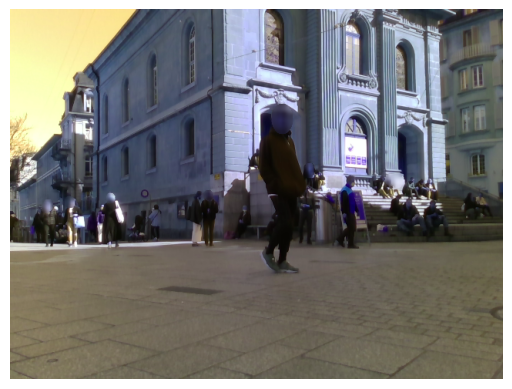

In [21]:
plt.axis('off')
plt.imshow(unpickled_df.iloc[445
                             ]["img_msgs"])

In [42]:
unpickled_df.iloc[1041]["detections"]

[[279,
  [-3.2723291423496175, -0.21280036753926124, 7.099],
  array([  0, 133,  69, 326]),
  [[35, 8, 0.31938383],
   [31, 4, 0.29643697],
   [39, 4, 0.40819383],
   [24, 8, 0.3990919],
   [40, 8, 0.3625872],
   [6, 35, 0.63615704],
   [52, 33, 0.71903276],
   [0, 69, 0.5105375],
   [65, 71, 0.68600047],
   [3, 92, 0.37812248],
   [64, 95, 0.60202074],
   [15, 89, 0.8679089],
   [42, 89, 0.87627584],
   [16, 130, 0.7577441],
   [44, 131, 0.8641723],
   [11, 178, 0.6751768],
   [42, 176, 0.8614564]],
  0.9972365498542786],
 [280,
  [-0.9472715030134929, -0.2018884465532153, 9.961],
  array([242, 191, 278, 280]),
  [[17, 4, 0.47532773],
   [16, 3, 0.5215485],
   [19, 2, 0.5292601],
   [14, 4, 0.61973],
   [21, 4, 0.6639788],
   [9, 14, 0.7635261],
   [26, 13, 0.64535147],
   [3, 30, 0.59618986],
   [27, 26, 0.3458749],
   [3, 39, 0.2826806],
   [20, 37, 0.14925452],
   [13, 41, 0.75713193],
   [23, 42, 0.8082744],
   [15, 63, 0.45078257],
   [21, 63, 0.26918533],
   [21, 84, 0.794479],


In [ ]:
imgs = unpickled_df.iloc[:]["img_msgs"]

bboxes = []
for d in unpickled_df.iloc[:]["detections"]:
    bbox_d = []
    scores_d = []
    for i in d:
        x_min, y_min, w, h = i[2]
        bbox_d.append([int(x_min), int(y_min), int(x_min+w), int(y_min+h)])
    bboxes.append(bbox_d)